In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import os 
from pathlib import Path
import subprocess
from sleepecg import compare_heartbeats

DatasetPath = "C:/Users/ARTAPC/Desktop/EcgSamples"  # Path to the MIT-BIH directory.


EpisodeNames = []

for file in os.listdir(DatasetPath):
    if file.endswith(".dat"):
        
        EpisodeNames.append( Path((file)).stem )

In [2]:
signal = []
actualpeaks = []

os.chdir(DatasetPath)

for ep in EpisodeNames:

    signals, fields= wfdb.rdsamp(ep)
    signal.append(signals[:,0])
    Annotations= wfdb.rdann(ep,'atr', return_label_elements=['symbol'])
    PeakSamples=Annotations.sample
    PeakSymbols=Annotations.symbol
    RealPeaksIndex=[]
    for index, sym in enumerate(PeakSymbols):
        if sym == 'N' or sym == 'V' or sym=='A':
            RealPeaksIndex=np.append(RealPeaksIndex, index)
    RealPeaksIndex= RealPeaksIndex.astype(int)
    RealPeaks=PeakSamples[RealPeaksIndex]

    actualpeaks.append(np.array([peak for peak in RealPeaks if peak < 500000]) )  

In [3]:
Exefile_Path = "C:/Users/ARTAPC/Desktop/test_alg/src"   # Path to where PanTompkins.exe is located.

os.chdir(Exefile_Path)

output=[]

for ep in signal:
        
    with open('ecg.txt', 'w') as f:
        for line in ep:
            f.write(f"{line}\n")


    open("output.txt", "w").close() # Clears output.txt after each Episode.

    subprocess.call(r"PanTompkins.exe", stdin=None, stdout=None, stderr=None, shell=False) # Calls PanTompkins.exe to write in output.txt

    with open('output.txt') as file:
        lines = np.array([line.rstrip() for line in file]) 
    
    output.append(np.array([int (l) for l in lines])) 

In [4]:
TruePositiveRate_recall=[]
PositivePredictiveValue_precision = []

for i,ep in enumerate(output):

    res = compare_heartbeats(ep,actualpeaks[i],max_distance=7)

    TruePositiveRate_recall.append(len(res.TP)/(len(res.TP)+len(res.FN)))    # Recall 
    PositivePredictiveValue_precision.append(len(res.TP)/(len(res.TP)+len(res.FP)))  # Accuracy


In [5]:
PositivePredictiveValue_precision

[1.0,
 0.9951657458563536,
 0.0590318772136954,
 1.0,
 0.0777479892761394,
 0.9714428857715431,
 0.9933598937583001,
 0.014594594594594595,
 0.6075709779179811,
 0.011819116135662899,
 0.0006195786864931846,
 0.9989816700610998,
 0.9955914768552535,
 0.9795769511305616,
 1.0,
 0.9978070175438597,
 0.9860627177700348,
 0.045402298850574715,
 0.7901639344262295,
 0.9956647398843931,
 1.0,
 1.0,
 0.030755711775043937,
 0.9852652259332023,
 0.9948377581120944,
 0.9910034602076124,
 0.9441758241758241,
 0.9922854387656702,
 0.025094102885821833,
 0.5962321792260692,
 1.0,
 0.9702170620898536,
 0.28277153558052437,
 0.8526231477773328,
 0.10683012259194395,
 0.9992269037495168,
 0.21631205673758866,
 0.995627732667083,
 1.0,
 0.8687782805429864,
 0.7706971677559913,
 0.9707513867876955,
 0.9605263157894737,
 1.0,
 0.26155187445510025,
 0.8057259713701431,
 0.9134697357203752,
 0.9764039641340255]

<BarContainer object of 48 artists>

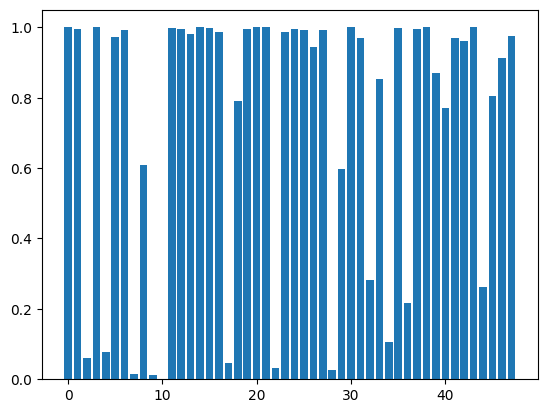

In [6]:
plt.bar(range(len(PositivePredictiveValue_precision)),PositivePredictiveValue_precision)